In [34]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go 
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from functools import reduce
import datetime as dt

#Validation
from sklearn.metrics import mean_squared_error
import math

#LSTM Model
from keras.layers import Dense,LSTM,Dropout
from keras.models import Sequential,Model
import keras
import pandas_datareader as pdr

import seaborn as sn
import matplotlib.pyplot as plt


In [35]:
close=pd.read_csv('data/close.csv')
adj_close=pd.read_csv('data/adj_close.csv')
open=pd.read_csv('data/open.csv')
high=pd.read_csv('data/open.csv')
low=pd.read_csv('data/low.csv')
volume=pd.read_csv('data/volume.csv')

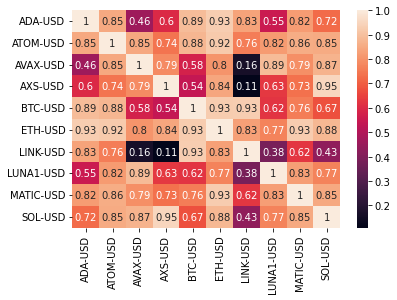

In [36]:
corrMatrix = close.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [37]:
dataframes = [close, adj_close, open, high, low, volume]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), dataframes)

C:\Users\renan\AppData\Local\Temp/ipykernel_1128/2867073563.py:2: FutureWarning: Passing 'suffixes' which cause duplicate columns {'AVAX-USD_x', 'LUNA1-USD_x', 'ADA-USD_x', 'MATIC-USD_x', 'AXS-USD_x', 'LINK-USD_x', 'BTC-USD_x', 'SOL-USD_x', 'ATOM-USD_x', 'ETH-USD_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), dataframes)


In [38]:
#Prepare datasets per currency

def currency(curr): 
    df=df_merged[['Date',curr+'_x', curr+'_y']]
    df.columns = ['Date','Close', 'Adj_Close','Open','High', 'Low', 'Volume']
    df = df.dropna()
    df['Date'] = pd.to_datetime(df['Date'])
    #df = df.loc[df['Date'].dt.year >= 2021]
    df = df.reset_index(drop=True)
    return df

ada=currency('ADA-USD')
atom=currency('ATOM-USD')
avax=currency('AVAX-USD')
axs=currency('AXS-USD')
btc=currency('BTC-USD')
eth=currency('ETH-USD')
link=currency('LINK-USD')
luna1=currency('LUNA1-USD')
matic=currency('MATIC-USD')
sol=currency('SOL-USD')

#Dictionary with crypto names and datasets
crypto_names = {'ADA-USD':ada, 
               'ATOM-USD':atom,
               'AVAX-USD':avax,
               'AXS-USD':axs,
               'BTC-USD':btc,
               'ETH-USD':eth,
               'LINK-USD':link,
               'LUNA1-USD':luna1,
               'MATIC-USD':matic,
               'SOL-USD':sol}

In [39]:
#DF preparing functions for Close and High, also splitting the training/test dataset
def lstm_close(curr):
    df=curr.reset_index()['Close']
    scaler=MinMaxScaler(feature_range=(0,1))
    df=scaler.fit_transform(np.array(df).reshape(-1,1))
    return scaler,df
    
def lstm_high(curr):
    df=curr.reset_index()['High']
    scaler=MinMaxScaler(feature_range=(0,1))
    df=scaler.fit_transform(np.array(df).reshape(-1,1))
    return scaler,df

def split_df(df):
    training_size=int(len(df)*0.75)
    test_size=len(df)-training_size
    train_data,test_data=df[0:training_size,:],df[training_size:len(df),:1]
    return train_data,test_data

#Using the provided data, create a dataset of sequential values using a timestep (number of days chosen)
def create_dataset(dataset, time_step):
    data_x, data_y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        data_x.append(a)
        data_y.append(dataset[i + time_step, 0])
    return np.array(data_x), np.array(data_y)


In [40]:
#Macro function to predict the next day for a certain coin.
'''
Parameters:
name - String with the name of the coin
df - dataframe for the coin
days - how many days to use as basis for predicting (standard: 15)
epochs - how many epochs for the LSTM to run (standard: 20)
market - if you want to predict the "close" or the "high" (standard: "close")
'''
def predict_coin(name,df,days=15,epochs=20,market='close'):
    #keep_dates = df['Date']
    market_options = ['close', 'high']
    if market not in market_options:
        raise ValueError("Invalid choice for market status. Must be 'high' or 'close'")
    #Scale and prepare the datasets to the model
    if market=='close':
        #Get scaler and "close" preprocessed df
        scaler,df1 = lstm_close(df)
    else: 
        scaler,df1 = lstm_high(df)
    #Split dataframe using 75% train size
    train_data, test_data = split_df(df1)
    
    #Set timestep of n days and create datasets to train
    time_step = days
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)
    
    #Reshaping the input as required for LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    #callbacks = [
    #  keras.callbacks.ModelCheckpoint(
    #      filepath="checkpoint.keras",
    #      monitor="val_loss",
    #      save_best_only=True
    #  ),
    #  keras.callbacks.EarlyStopping(
    #      monitor="val_accuracy",
    #      patience=10,
    #    )
    #]
        
    #Create LSTM model using layers and dropout to avoid overfitting
    model=Sequential()
    model.add(LSTM(50,return_sequences=True,input_shape=(days,1)))
    model.add(Dropout(0.2))
    model.add(LSTM(50,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))    
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    #Fit the model and predict for X_train and X_test. 
    #After that, present the RMSE for train and test    
    print(f"Running epochs for {name} now, it might take a while")
    model.fit(X_train, y_train, validation_data=(X_test,y_test),epochs=epochs, batch_size=64,verbose=0)
    
    train_predict=model.predict(X_train)
    test_predict=model.predict(X_test)

    print(f"RMSE for {name} train data")
    print(math.sqrt(mean_squared_error(y_train,train_predict)))
    print(f"RMSE for {name} test data")
    print(math.sqrt(mean_squared_error(y_test,test_predict)))
    
    train_predict=scaler.inverse_transform(train_predict)
    test_predict=scaler.inverse_transform(test_predict)
    #Plotting
    # Train predictions plot
    look_back=days
    trainPredictPlot = np.empty_like(df1)
    trainPredictPlot[:,:] = np.nan
    trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
    
    # Test predictions plot
    testPredictPlot = np.empty_like(df1)
    testPredictPlot[:,:] = np.nan
    testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
    
    #plot original data and predictions with x-axis date information
    temp_df = pd.DataFrame()
    temp_df['Date'] = df['Date']
    temp_df['Train'] = trainPredictPlot
    temp_df['Test'] = testPredictPlot
    temp_df['Data'] = scaler.inverse_transform(df1)
    temp_df.set_index('Date', inplace=True)
    plt.figure(figsize=(14, 4))
    plt.plot(temp_df['Data'])
    plt.plot(temp_df['Train'])
    plt.plot(temp_df['Test'])
    plt.xlabel('Date')
    plt.xticks(rotation='45')
    plt.ylabel("Value in USD")
    plt.title(f"Prediction x Actual for {name}", fontweight='bold')
    plt.legend(['Actual Data', 'TrainPred', 'TestPred'])
    plt.show()
    
    #Reshaping only the last n values for test data
    x_input=test_data[len(test_data)-days:].reshape(1,-1)
    x_input.shape

    #Predict the next day
    predictions = model.predict(x_input, verbose=0)
    predictions = scaler.inverse_transform(predictions)
    print(f"{name} prediction for next day: {predictions[0]} USD\n\n")
    return float(predictions)
    

Running epochs for ADA-USD now, it might take a while
RMSE for ADA-USD train data
0.00974179001710696
RMSE for ADA-USD test data
0.039332553744630946


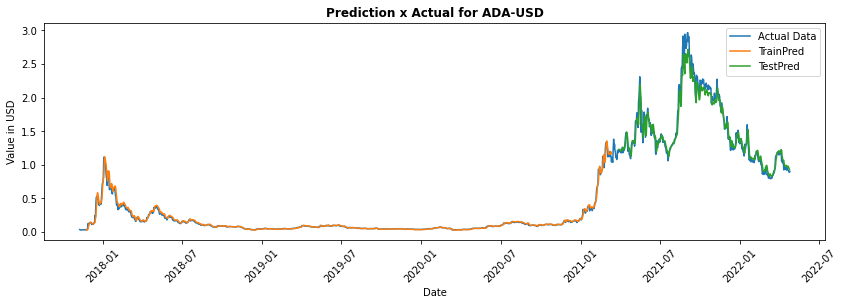

ADA-USD prediction for next day: [0.92326665] USD


Running epochs for ATOM-USD now, it might take a while
RMSE for ATOM-USD train data
0.024271953065629535
RMSE for ATOM-USD test data
0.06037407267903591


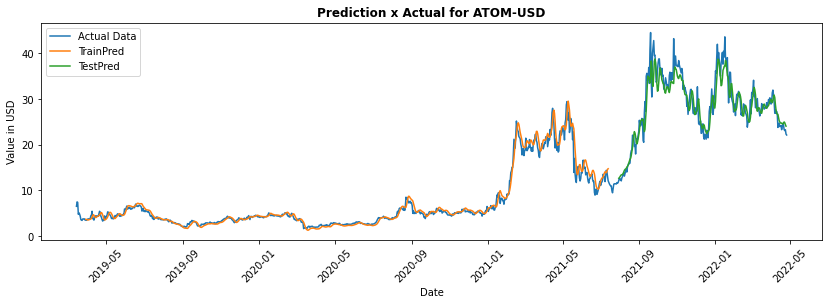

ATOM-USD prediction for next day: [23.212109] USD


Running epochs for AVAX-USD now, it might take a while
RMSE for AVAX-USD train data
0.04075185585272622
RMSE for AVAX-USD test data
0.0753662067467227


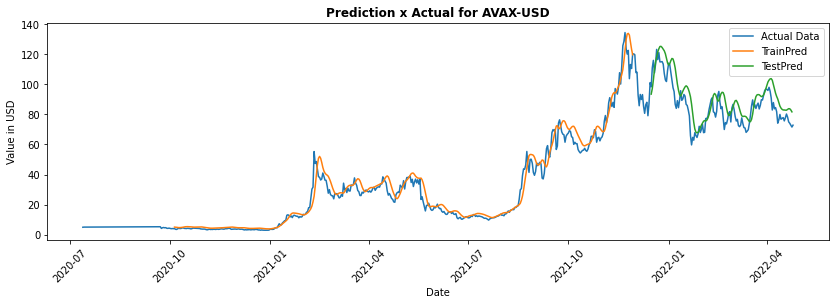

AVAX-USD prediction for next day: [78.836365] USD


Running epochs for AXS-USD now, it might take a while
RMSE for AXS-USD train data
0.049480105684141476
RMSE for AXS-USD test data
0.09371390406877948


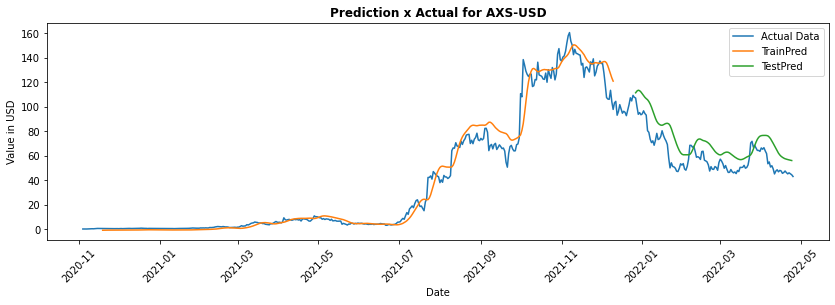

AXS-USD prediction for next day: [55.280746] USD


Running epochs for BTC-USD now, it might take a while
RMSE for BTC-USD train data
0.011526533480000555
RMSE for BTC-USD test data
0.050449791271148604


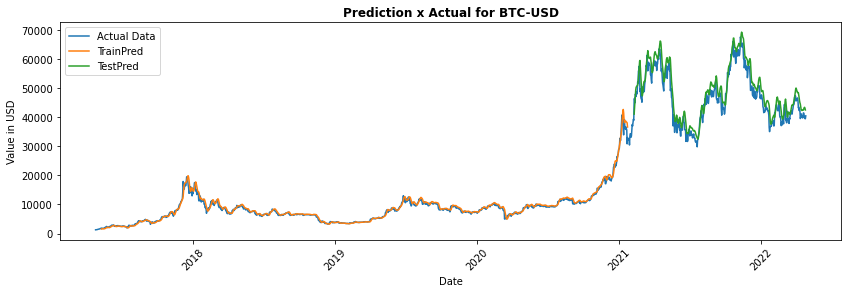

BTC-USD prediction for next day: [41842.3] USD


Running epochs for ETH-USD now, it might take a while
RMSE for ETH-USD train data
0.008765501836294399
RMSE for ETH-USD test data
0.048611996116309036


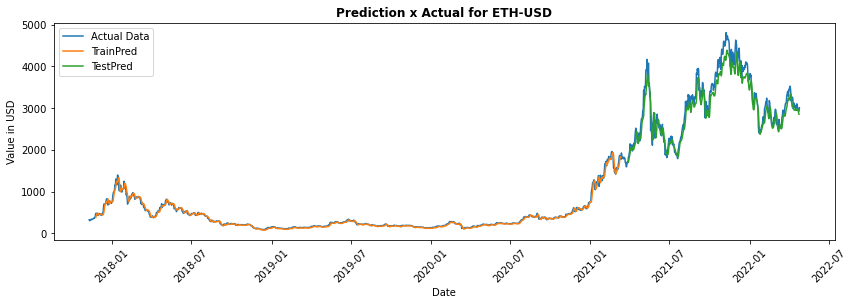

ETH-USD prediction for next day: [2850.9038] USD


Running epochs for LINK-USD now, it might take a while
RMSE for LINK-USD train data
0.013711514667346261
RMSE for LINK-USD test data
0.04308520880735183


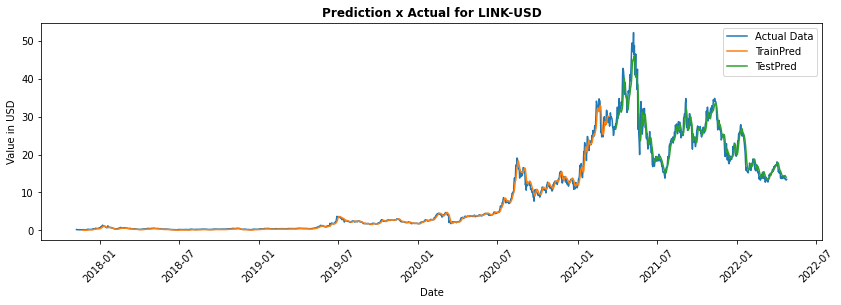

LINK-USD prediction for next day: [13.745967] USD


Running epochs for LUNA1-USD now, it might take a while
RMSE for LUNA1-USD train data
0.006276569432023362
RMSE for LUNA1-USD test data
0.17024544813772213


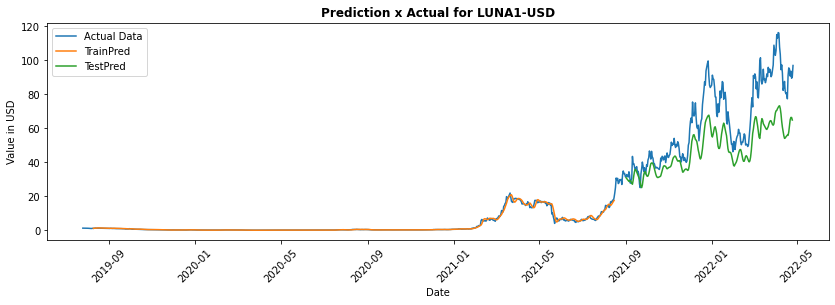

LUNA1-USD prediction for next day: [62.56368] USD


Running epochs for MATIC-USD now, it might take a while
RMSE for MATIC-USD train data
0.02464369135099788
RMSE for MATIC-USD test data
0.0529210619021116


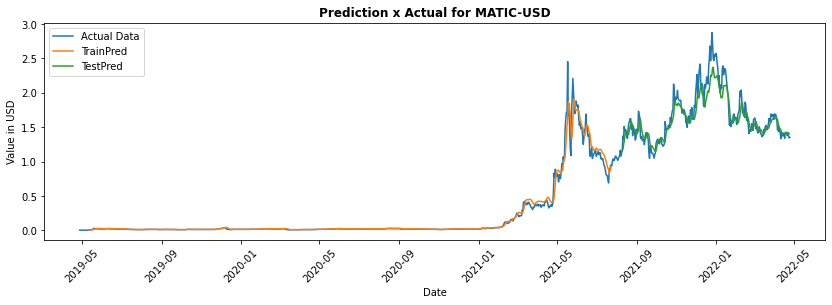

MATIC-USD prediction for next day: [1.3821759] USD


Running epochs for SOL-USD now, it might take a while


In [ ]:
#Create a dictionary with names and predictions for all coins. Parameters used: prediction based on last 15 days, 100 epochs.
crypto_predictions = {}
for key,value in crypto_names.items():
    crypto_predictions[f'{key}'] = predict_coin(key,value,days=15,epochs=100,market='close') 

In [ ]:
predict_coin('eth',eth,days=15,epochs=100,market='close')

In [362]:
#actual_values = []
#for i in crypto_names.keys():
#    i = pdr.DataReader(i, data_source='yahoo', start='2022-04-26', end='2022-04-26')
#    i = i.iloc[:1]
#    actual_values.append(i['Close'][0])

In [363]:
data = pd.DataFrame()
data['Index'] = (list(crypto_names.keys()))
data['Pred'] = list(crypto_predictions.values())
data['Actual'] = actual_values
data.set_index('Index', inplace=True)

In [364]:
data

,Pred,Actual
Index,,
ADA-USD,0.848718,0.827645
ATOM-USD,21.496635,20.346748
AVAX-USD,72.075378,68.672058
AXS-USD,51.622169,38.687870
BTC-USD,37050.402344,38117.460938
ETH-USD,2699.788574,2808.298340
LINK-USD,13.570720,12.354577
LUNA1-USD,67.617279,88.550468
MATIC-USD,1.285170,1.242833
